In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
import tensorflow.keras.layers as Layers
import keras.backend as K


# CUDA Setup

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Read Data

In [72]:
WIDTH = 256
HEIGHT = 256

def read_data(image_file):
	resize = lambda x: tf.image.resize(x, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
	normalize = lambda x: (x / 127.5) - 1

	image = tf.io.read_file(image_file)
	image = tf.image.decode_jpeg(image, channels=3)
	
	w = tf.shape(image)[1] // 2
	satellite = image[:, :w, :]
	map = image[:, w:, :]

	satellite = tf.cast(satellite, tf.float32)
	map = tf.cast(map, tf.float32)

	map = normalize(resize(map))
	satellite = normalize(resize(satellite))
	
	return map, satellite

In [83]:
train_dataset = tf.data.Dataset.list_files('../data/maps/train/' + '*.jpg')
train_dataset = train_dataset.map(read_data)
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.batch(1)

In [84]:
test_dataset = tf.data.Dataset.list_files('../data/maps/val/' + '*.jpg')
test_dataset = test_dataset.map(read_data)
test_dataset = test_dataset.batch(1)

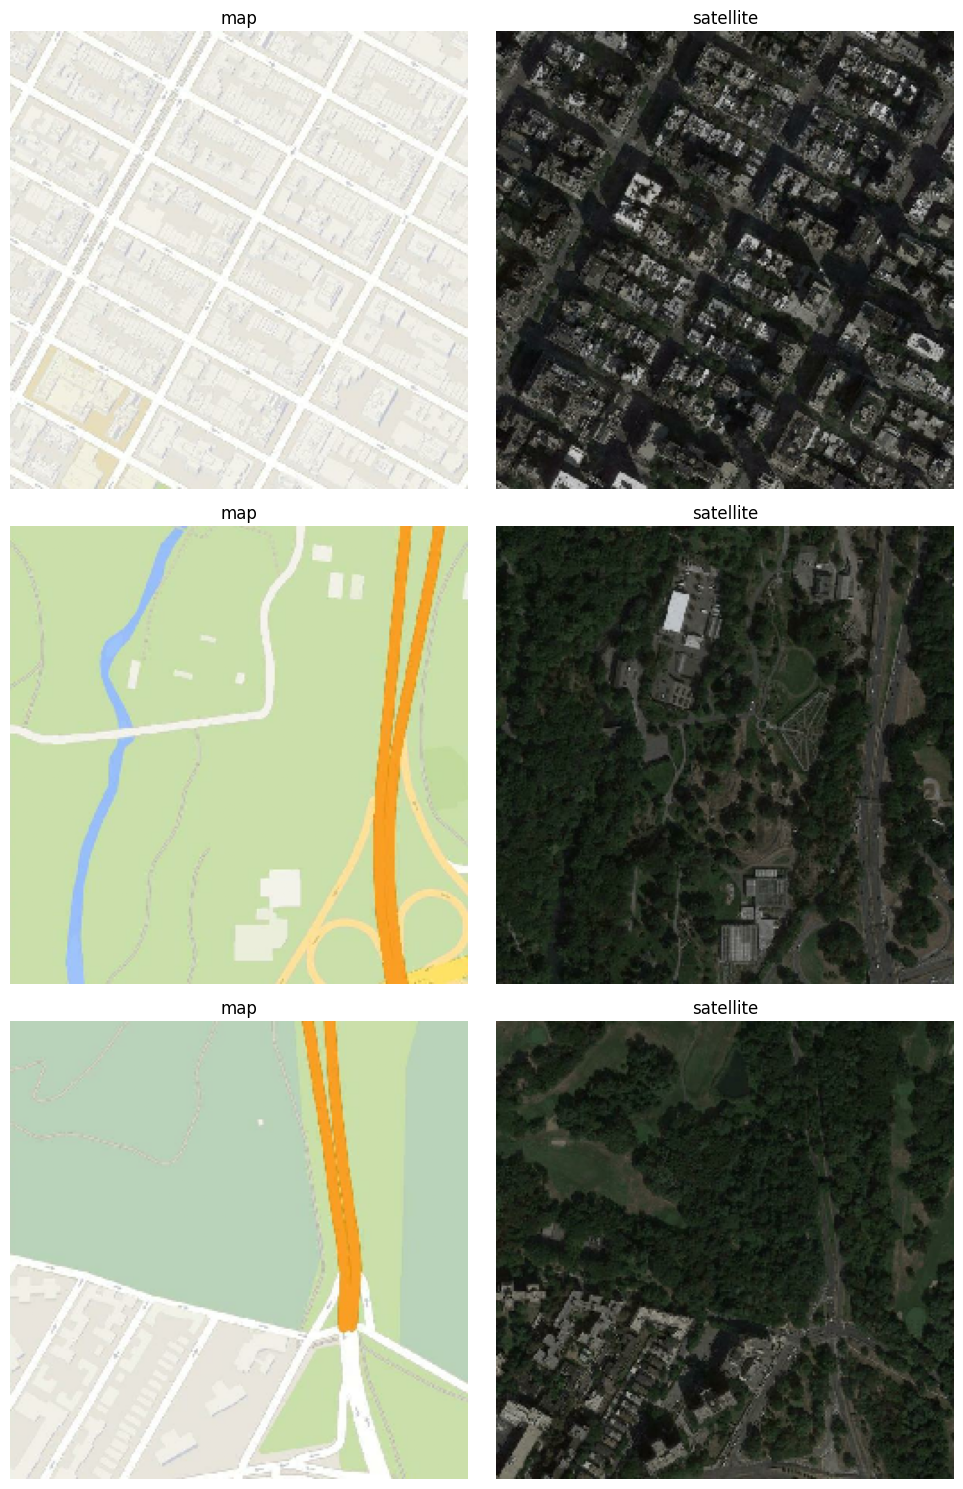

In [85]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
i = 0
for map, satellite in train_dataset.take(3):
	axes[i][0].imshow(map[0] * 0.5 + 0.5)
	axes[i][0].set_title('map')
	axes[i][0].axis('off')
	axes[i][1].imshow(satellite[0] * 0.5 + 0.5)
	axes[i][1].set_title('satellite')
	axes[i][1].axis('off')
	i += 1
fig.tight_layout()
plt.show()

# Model

## Generator

In [86]:
def downsample(filters, size, batchnorm=True):
	initializer = tf.random_normal_initializer(0., 0.02)
	block = keras.Sequential()
	block.add(
		Layers.Conv2D(
			filters, 
			size, 
			strides=2, 
			padding='same',
			kernel_initializer = initializer, 
			use_bias=False
		)
	)
	if batchnorm:
		block.add(Layers.BatchNormalization())
	block.add(Layers.LeakyReLU())
	return block

In [87]:
def upsample(filters, size, dropout=False):
	initializer = tf.random_normal_initializer(0., 0.02)
	block = keras.Sequential()
	block.add(
		Layers.Conv2DTranspose(
			filters, 
			size, 
			strides=2,
			padding='same',
			kernel_initializer=initializer,
			use_bias=False
		)
	)
	block.add(Layers.BatchNormalization())
	if dropout:
		block.add(Layers.Dropout(0.5))
	block.add(Layers.ReLU())

	return block

In [58]:
def Generator():
	inputs = Layers.Input(shape=[256, 256, 3])

	down_stack = [
		downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
		downsample(128, 4),  # (batch_size, 64, 64, 128)
		downsample(256, 4),  # (batch_size, 32, 32, 256)
		downsample(512, 4),  # (batch_size, 16, 16, 512)
		downsample(512, 4),  # (batch_size, 8, 8, 512)
		downsample(512, 4),  # (batch_size, 4, 4, 512)
		downsample(512, 4),  # (batch_size, 2, 2, 512)
		downsample(512, 4),  # (batch_size, 1, 1, 512)
	]

	up_stack = [
		upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
		upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
		upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
		upsample(512, 4),  # (batch_size, 16, 16, 1024)
		upsample(256, 4),  # (batch_size, 32, 32, 512)
		upsample(128, 4),  # (batch_size, 64, 64, 256)
		upsample(64, 4),  # (batch_size, 128, 128, 128)
	]
	
	initializer = tf.random_normal_initializer(0., 0.02)
	last = Layers.Conv2DTranspose(
		3, 
		4,
		strides=2,
		padding='same',
		kernel_initializer=initializer,
		activation='tanh'
	)  # (batch_size, 256, 256, 3)

	x = inputs

	# Downsampling through the model
	skips = []
	for down in down_stack:
		x = down(x)
		skips.append(x)

	skips = reversed(skips[:-1])

	# Upsampling and establishing the skip connections
	for up, skip in zip(up_stack, skips):
		x = up(x)
		x = Layers.Concatenate()([x, skip])

	x = last(x)

	return keras.Model(inputs=inputs, outputs=x)

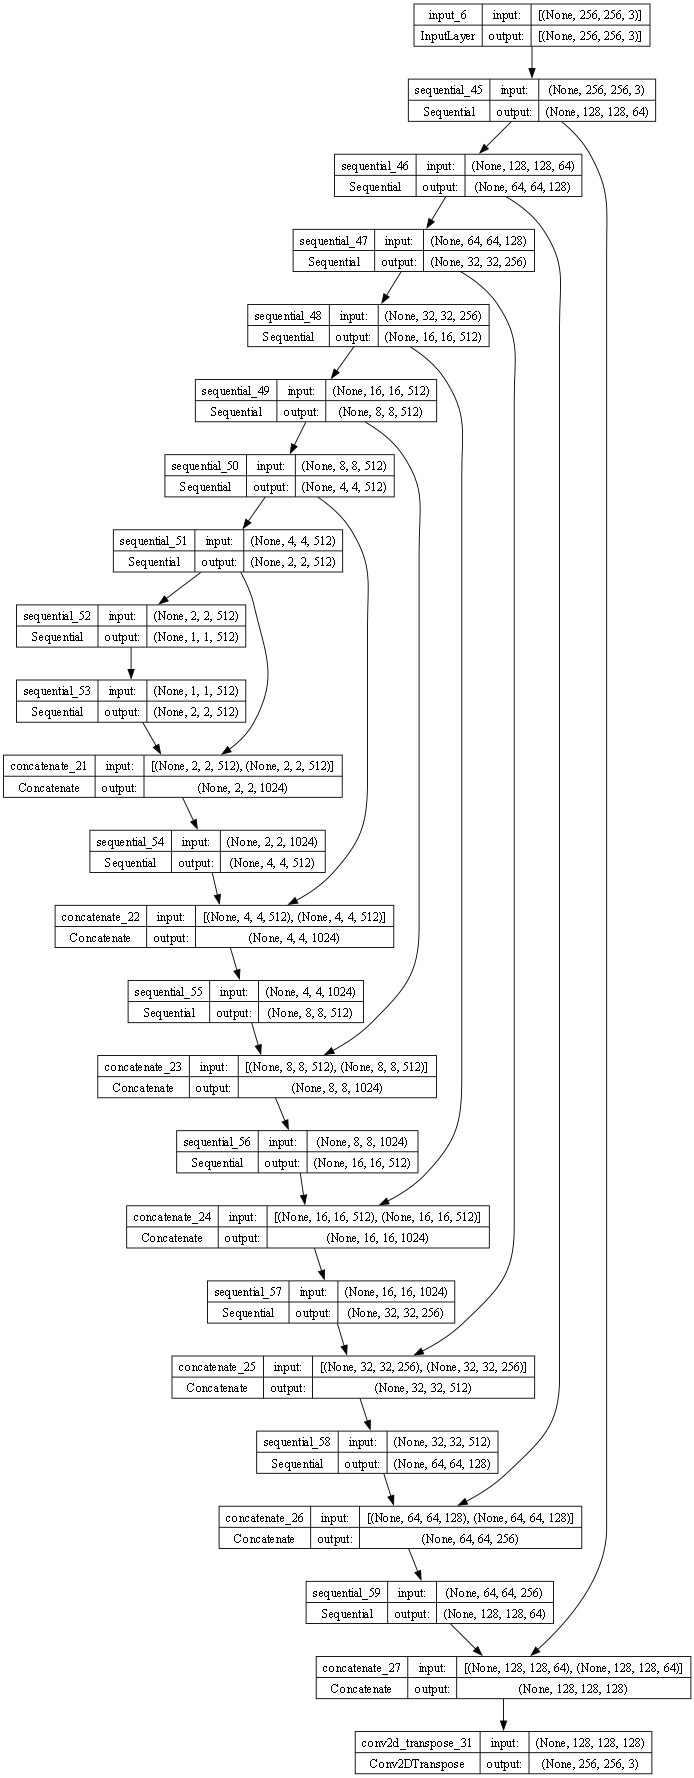

In [63]:
generator = Generator()
plot_model(generator, show_shapes=True, dpi=64)

In [64]:
LAMBDA = 100
bce = keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = bce(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

## Discriminator

In [65]:
def Discriminator():
	initializer = tf.random_normal_initializer(0., 0.02)

	input = Layers.Input(shape=[256, 256, 3], name='input_image')
	target = Layers.Input(shape=[256, 256, 3], name='target_image')

	x = Layers.concatenate([input, target])  # (batch_size, 256, 256, channels*2)
	x = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
	x = downsample(128, 4)(x)  # (batch_size, 64, 64, 128)
	x = downsample(256, 4)(x)  # (batch_size, 32, 32, 256)
	x = Layers.ZeroPadding2D()(x)  # (batch_size, 34, 34, 256)
	x = Layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (batch_size, 31, 31, 512)
	x = Layers.BatchNormalization()(x)
	x = Layers.LeakyReLU()(x)
	x = Layers.ZeroPadding2D()(x)  # (batch_size, 33, 33, 512)
	last = Layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (batch_size, 30, 30, 1)

	return keras.Model(inputs=[input, target], outputs=last)

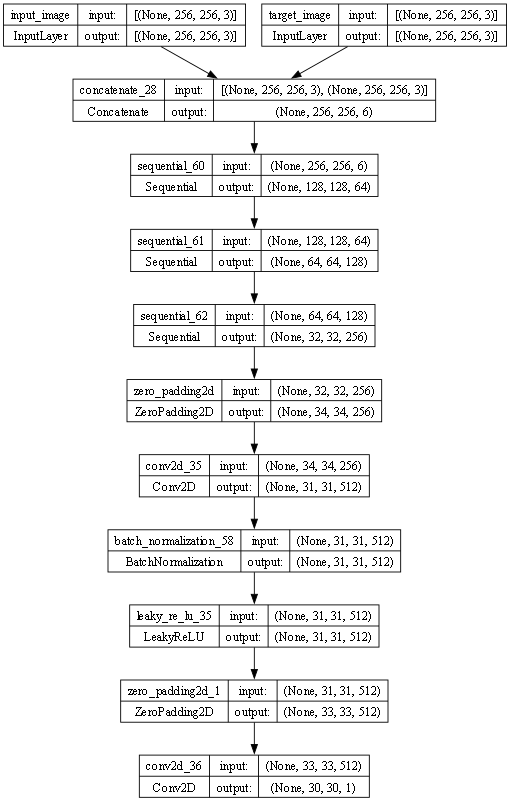

In [66]:
discriminator = Discriminator()
keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [67]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = bce(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = bce(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

# Training

In [68]:
generator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

In [69]:
def generate_images(model, input, target):
	prediction = model(input, training=True)
	plt.figure(figsize=(15,15))

	display_list = [input[0], target[0], prediction[0]]
	title = ['Input Image', 'Ground Truth', 'Predicted Image']

	for i in range(3):
		plt.subplot(1, 3, i + 1)
		plt.title(title[i])
		plt.imshow(display_list[i] * 0.5 + 0.5)
		plt.axis('off')
	plt.show()

In [19]:
gen_gan_loss_list = []
gen_l1_loss_list = []
gen_total_loss_list = []
disc_loss_list = []
data = 0

@tf.function
def train_step(input_image, target, step):
	with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
		gen_output = generator(input_image, training=True)

		disc_real_output = discriminator([input_image, target], training=True)
		disc_generated_output = discriminator([input_image, gen_output], training=True)

		gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
		disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
	# if (step) % 1000 == 0:
	# 	if step != 0:
	# 		tf.print('Discriminator loss: ', disc_loss)
	# 		tf.print('Generator GAN loss: ',gen_gan_loss)
	# 		tf.print('Generator L1 loss: ',gen_l1_loss)
	# 		tf.print('Generator total loss: ',gen_total_loss)
		
	generator_gradients = gen_tape.gradient(gen_total_loss,
											generator.trainable_variables)
	discriminator_gradients = disc_tape.gradient(disc_loss,
												discriminator.trainable_variables)

	generator_optimizer.apply_gradients(zip(generator_gradients,
											generator.trainable_variables))
	discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
												discriminator.trainable_variables)) 	

In [70]:
def fit(train_dataset, epochs, test_dataset):
	print("Epoch: ", 0)
	for epoch in range(epochs):
		for map, satellite in test_dataset.take(5):
			generate_images(generator, map, satellite)
		print("Epoch: ", epoch)
		for n, (input_image, target) in train_dataset.enumerate():		
			train_step(input_image, target, epoch)
		print()


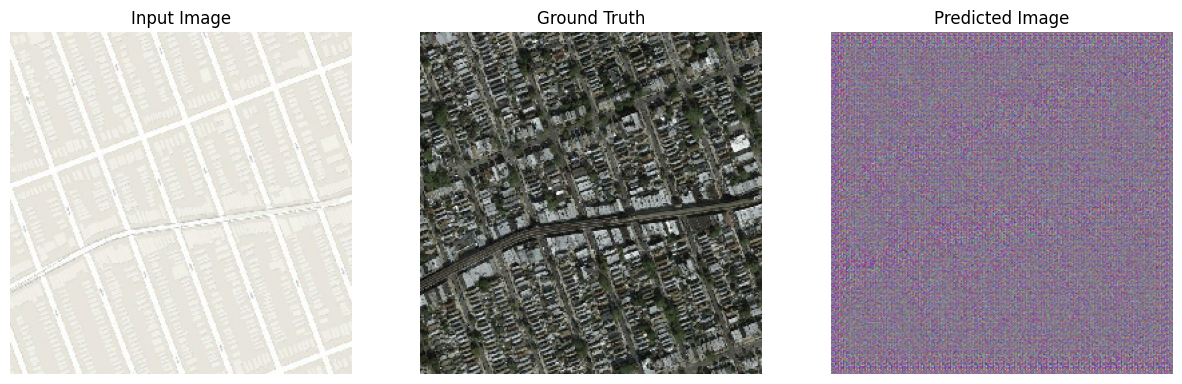

Epoch:  0


KeyboardInterrupt: 

In [21]:
fit(train_dataset, 15, test_dataset)